In [9]:
%matplotlib widget

In [10]:

import adafruit_bno055
import busio# I2C用のインターフェースを使用するためのモジュール
import board
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
path = os.getcwd()
from IPython.display import display, clear_output
from collections import deque
from time import perf_counter

In [11]:
        
def connect():
    i2c = busio.I2C(board.SCL, board.SDA)# I2CBusにアクセスするためのインターフェースを用意。SCLとSDAを使ってアクセス
    bno = adafruit_bno055.BNO055_I2C(i2c)# BNO055センサに接続する。DefaultではNDOF_MODE(12)
    #self.bno.use_external_crystal = True
    print("Established connection with BNO055")
    return i2c, bno
        

In [12]:
def get_data(bno):
        
    '''
    センサからある時点の値を抽出
    '''
        
    euler_x, euler_y, euler_z = [val for val in bno.euler]# 角度[deg]
    gyro_x, gyro_y, gyro_z = [val for val in bno.gyro]# 角速度[rad/s]
    gravity_x, gravity_y, gravity_z = [val for val in bno.gravity]# 重力加速度[m/s^2]
    linear_accel_x, linear_accel_y, linear_accel_z = [val for val in bno.linear_acceleration]# 重力分を差し引いた加速度[m/s^2]
    accel_x, accel_y, accel_z = [val for val in bno.acceleration]# 重力+リニア加速度
    quaternion_1, quaternion_2, quaternion_3, quaternion_4 = [val for val in bno.quaternion]# クオータニオン
    calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag = [val for val in bno.calibration_status]# キャリブレーション状態
        
    return euler_x, euler_y, euler_z, gyro_x, gyro_y, gyro_z, gravity_x, gravity_y, gravity_z,\
            linear_accel_x, linear_accel_y, linear_accel_z, accel_x, accel_y, accel_z,\
            quaternion_1, quaternion_2, quaternion_3, quaternion_4,\
            calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag
    

In [13]:

def measure(bno):
    
    IsMonitor = True
    try:
        print('Measurement start')      
        plt.ion()
        fig, ax = plt.subplots(3, 1, tight_layout=True)
        fig.set_figheight(8)
        fig.set_figwidth(12)
        """
        
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Longitudinal acceleration [m/s^2]")
        ax[1].set_xlabel("Time [s]")
        ax[1].set_ylabel("Lateral acceleration [m/s^2]")
        ax[2].set_xlabel("Time [s]")
        ax[2].set_ylabel("Yaw rate [rad/s]")
        """        
        
        
        counter = 0
        Logic_start_time = time.time()#計測用
        while True:
            start_time = time.time()# ループの一番最初
            Time = counter / BNO_UPDATE_FREQUENCY_HZ# 現在の時刻
            '''
            Time, euler_x, euler_y, euler_z, gyro_x, gyro_y, gyro_z, gravity_x, gravity_y, gravity_z,\
            linear_accel_x, linear_accel_y, linear_accel_z, accel_x, accel_y, accel_z,\
            quaternion_1, quaternion_2, quaternion_3, quaternion_4,\
            calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag]
            '''                 
            #from IPython.core.debugger import Pdb; Pdb().set_trace()
            data = np.array([Time] + list(get_data(bno))).reshape(-1, len(COLUMNS))#センサからデータを抽出しTimeの結合
            
                        
            if counter == 0:
                assy_data = data.copy()

            else: 
                assy_data = np.concatenate((assy_data, data), axis = 0)# 行方向に結合

            if BNO_UPDATE_FREQUENCY_HZ <= 1.0:
            
                #Queue operation               
                Time_data.popleft()
                linear_accel_x_data.popleft()
                linear_accel_y_data.popleft()
                linear_accel_z_data.popleft()
                gyro_x_data.popleft()
                gyro_y_data.popleft()
                gyro_z_data.popleft()
                
                Time_data.append(data[-1,0])
                linear_accel_x_data.append(data[-1,10])
                linear_accel_y_data.append(data[-1,11])
                linear_accel_z_data.append(data[-1,12])
                gyro_x_data.append(data[-1,4])
                gyro_y_data.append(data[-1,5])
                gyro_z_data.append(data[-1,6])         
                
                
                # Graph
                # 極力グラフを書くだけにとどめる
                clear_output(wait = True)
                plt.cla()
                ax[0].plot(Time_data,linear_accel_x_data,linestyle='-', color='r', linewidth=1)
                ax[1].plot(Time_data,linear_accel_y_data,linestyle='-', color='r', linewidth=1)
                ax[2].plot(Time_data,np.rad2deg(gyro_z_data),linestyle='-', color='r', linewidth=1)# グラフ化の時はrad2degにしておく
                display(fig)
            
            
            executed_time = time.time()# ある関数が終わった直後
            wait_process((1.0 / BNO_UPDATE_FREQUENCY_HZ) - (executed_time - start_time))
            counter += 1            
            
            
    except KeyboardInterrupt:
        end_time = time.time()
        # 経過時間を出力(秒)
        elapsed_time = end_time - Logic_start_time
        print(elapsed_time)
        print('executed ctrl-c')
        assy_data = pd.DataFrame(assy_data, columns=list(COLUMNS))
        assy_data.to_csv(datapath + '/'+ str(time.time()) +'_data.csv')
        return assy_data
    
    return
            


In [14]:
def wait_process(wait_sec):
    until = perf_counter() + wait_sec
    while perf_counter() < until:
        pass
    return

Start Application
Established connection with BNO055
Measurement start
11.819985151290894
executed ctrl-c


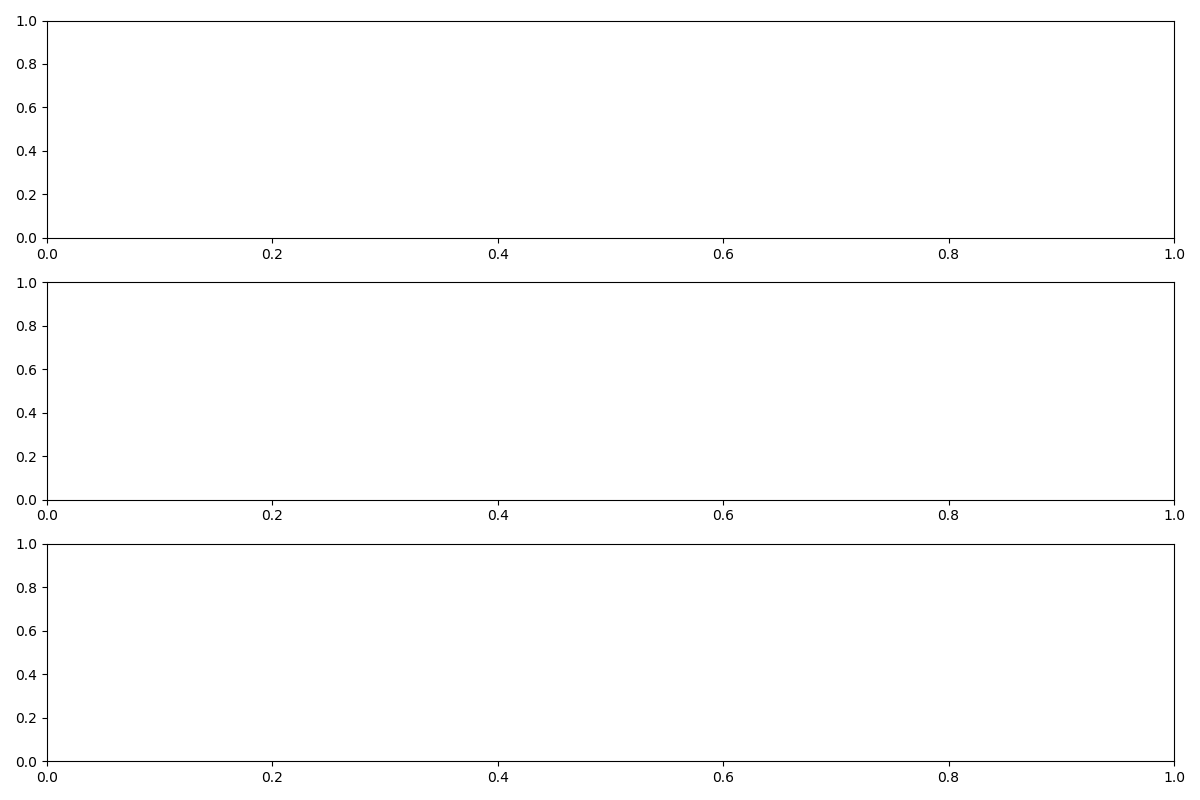

In [15]:
if __name__ == '__main__':
    

    IsStartStop = False# False:Stop, True:Start
    IsMonitor = False# False:Not monitoring, True:Monitoring
    BNO_UPDATE_FREQUENCY_HZ = 10#OK:10Hz / 20Hz / 30Hz NG:100Hz、40Hz、50は無理
    
    COLUMNS = ["Time","euler_x", "euler_y", "euler_z", "gyro_x", "gyro_y", "gyro_z", "gravity_x", "gravity_y", "gravity_z",
                "linear_accel_x", "linear_accel_y", "linear_accel_z","accel_x", "accel_y", "accel_z",
                "quaternion_1", "quaternion_2", "quaternion_3", "quaternion_4", 
                "calibstat_sys", "calibstat_gyro", "calibstat_accel", "calibstat_mag"]
    exepath = path + '/measurement_system'
    datapath = path + '/data'
    
    INTERVAL = 1000
    INIT_LEN = INTERVAL // BNO_UPDATE_FREQUENCY_HZ

    Time_data = deque(np.zeros(INIT_LEN))# Time
    linear_accel_x_data = deque(np.zeros(INIT_LEN))# linear_accel_x
    linear_accel_y_data = deque(np.zeros(INIT_LEN))# linear_accel_y
    linear_accel_z_data = deque(np.zeros(INIT_LEN))# linear_accel_z
    gyro_x_data = deque(np.zeros(INIT_LEN))# gyro_x
    gyro_y_data = deque(np.zeros(INIT_LEN))# gyro_y
    gyro_z_data = deque(np.zeros(INIT_LEN))# gyro_z
    
    
    
    
    
    print('Start Application')
 
    i2c, bno = connect()    
    assy_data = measure(bno)
